In [ ]:
import xarray as xr
import numpy as np
import glob  # For file listing
import datetime
import matplotlib.ticker as tkr
from scipy import interpolate
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
from IPython.display import Image
import yaml
import matplotlib.ticker as tkr
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker

In [2]:
# Read the initial conditions of the far-field (from final near-field)

with open("Init.yaml", "r") as file:
    Init = yaml.safe_load(file)

init_lon = Init["init_lon"]
init_lat = Init["init_lat"]

init_depth = Init["init_depth"]
output_dt = Init["output_dt"]  # minutes
ocean_data_path = Init["ocean_data_path"]
parcels_data_path = Init["parcels_data_path"]

npart = Init["npart"]


In [3]:
# Create folder with plots

plot_folder_path = parcels_data_path + "/PLOTS"
os.makedirs(plot_folder_path, exist_ok=True)

In [4]:
# read the parcels simulation output data
    # obs variable is the observation (time)
    # trajectory variable is the specific particle

data_xarray = xr.open_zarr(parcels_data_path)
data_xarray

<xarray.Dataset> Size: 3MB
Dimensions:     (trajectory: 1000, obs: 96)
Coordinates:
  * obs         (obs) int32 384B 0 1 2 3 4 5 6 7 8 ... 88 89 90 91 92 93 94 95
  * trajectory  (trajectory) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
Data variables:
    lat         (trajectory, obs) float64 768kB dask.array<chunksize=(1000, 1), meta=np.ndarray>
    lon         (trajectory, obs) float64 768kB dask.array<chunksize=(1000, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] 768kB dask.array<chunksize=(1000, 1), meta=np.ndarray>
    w_buoy      (trajectory, obs) float32 384kB dask.array<chunksize=(1000, 1), meta=np.ndarray>
    z           (trajectory, obs) float64 768kB dask.array<chunksize=(1000, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        BuoyParticleAdvectionRK4_3DDiffusionUniformKhDele...
    parcels_mesh:           spherical
    parcels_version:        3.1.2

In [5]:
# nobs number of observations

nobs = len(data_xarray.obs)

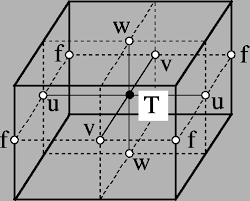

In [6]:
def getRangeIndexes(arr, var_min, var_max):
    return np.where((arr >= var_min) & (arr <= var_max))[0]

Image("arakawaC.png")

In [7]:
#### PLOT CONFIGURATION ##################
# SET GRID LIMITS

ds_w = xr.open_mfdataset("./data/Medsea_native/1995/rea_1995*_grid_W.nc")
ds_u = xr.open_mfdataset("./data/Medsea_native/1995/rea_1995*_grid_U.nc")
ds_v = xr.open_mfdataset("./data/Medsea_native/1995/rea_1995*_grid_V.nc")
ds_T = xr.open_mfdataset("./data/Medsea_native/1995/rea_1995*_grid_T.nc")
ds_mask = xr.open_dataset("./data/Medsea_native/1995/mesh_mask.nc")

## Configure the spatial temporal range for plotting

####### Set time limits #######
start_date = np.datetime64(datetime.datetime(1995,8,1,12))
end_date = start_date + np.timedelta64(0, 'D')
itimes = getRangeIndexes(ds_u['time_counter'].values, start_date, end_date)
times = ds_u['time_counter'][itimes]

## Set depthT limits gridT 
depthmin_T = ds_T['deptht'].min().values
depthmax_T = ds_T['deptht'].max().values
idepth_T = getRangeIndexes(ds_T['deptht'][:].values, depthmin_T, depthmax_T)
depth_T = ds_T['deptht'][idepth_T]

## Set lat-lon limits gridT 
lonmin = init_lon - 0.3
lonmax = init_lon + 0.3
latmin = init_lat - 0.3
latmax = init_lat + 0.3

# lonmin = init_lon - 1.6
# lonmax = init_lon + 1.3
# latmin = init_lat - 1.2
# latmax = init_lat + 0.8

ilon_T = getRangeIndexes(ds_mask['glamt'][0,0,:].values, lonmin, lonmax)
ilat_T = getRangeIndexes(ds_mask['gphit'][0,:,0].values, latmin, latmax)
lon2d_T = ds_mask['glamt'][0,ilat_T,ilon_T]
lat2d_T = ds_mask['gphit'][0,ilat_T,ilon_T]

## Set lat-lon limits gridU (same size of gridT)

ilon_U = getRangeIndexes(ds_mask['glamt'][0,0,:].values, lonmin, lonmax)
ilat_U = getRangeIndexes(ds_mask['gphit'][0,:,0].values, latmin, latmax)
lon2d_U = ds_mask['glamt'][0,ilat_U,ilon_U]
lat2d_U = ds_mask['gphit'][0,ilat_U,ilon_U]

## Set lat-lon limits gridV 

ilon_V = getRangeIndexes(ds_mask['glamt'][0,0,:].values, lonmin, lonmax)
ilat_V = getRangeIndexes(ds_mask['gphit'][0,:,0].values, latmin, latmax)
lon2d_V = ds_mask['glamt'][0,ilat_V,ilon_V]
lat2d_V = ds_mask['gphit'][0,ilat_V,ilon_V]

# Set mask limits gridT arrays  
mask_T = ds_mask['tmask'][0,:,ilat_T,ilon_T]
mask_U = ds_mask['umask'][0,:,ilat_U,ilon_U]
mask_V = ds_mask['vmask'][0,:,ilat_V,ilon_V]






In [8]:
## Select the depth where you want plot the horizontal currents
mydepth = 15
np.squeeze(depth_T)
imydepth = np.where((depth_T[:].values >= mydepth))[0][0]
imydepth

np.int64(6)

In [9]:

## Define levels for the contours
vel_min,vel_max = 0.001,0.4
vlevs = np.linspace(vel_min, vel_max, 30)

## Generate the maps for the selected time period
for obs in range(0,nobs,4):
    for i, time in enumerate(times):
        
        # Create a figure with Equidist-Cylindrical proj.
        proj = ccrs.PlateCarree()
        fig,ax=plt.subplots(subplot_kw=dict(projection=proj), figsize=(8, 8))
    
    
        # Select the U data to plot
        velUxy_U = ds_u['vozocrtx'].sel(time_counter=time).isel(depthu=imydepth).isel(x=ilon_U).isel(y=ilat_U)
        velUxy_U.values = np.where(mask_U[imydepth,:,:]==0, np.nan, velUxy_U.values)
        # Interpolate U data on T-grid
        velUxy_T = xr.DataArray(
            data = interpolate.griddata((lon2d_U.values.flatten(),lat2d_U.values.flatten()), velUxy_U.values.flatten(), (lon2d_T.values,lat2d_T.values), method='linear'),
            dims=["y", "x"],
            coords=dict(
                nav_lon=(["y", "x"], lon2d_T.values),
                nav_lat=(["y", "x"], lat2d_T.values),
                time_counter = velUxy_U['time_counter'],
            ),
        )
        
        # Select the V data to plot
        velVxy_V = ds_v['vomecrty'].sel(time_counter=time).isel(depthv=imydepth).isel(x=ilon_V).isel(y=ilat_V)
        velVxy_V.values = np.where(mask_V[imydepth,:,:]==0, np.nan, velVxy_V.values)
        # Interpolate V data on T-grid
        velVxy_T = xr.DataArray(
            data = interpolate.griddata((lon2d_V.values.flatten(),lat2d_V.values.flatten()), velVxy_V.values.flatten(), (lon2d_T.values,lat2d_T.values), method='linear'),
            dims=["y", "x"],
            coords=dict(
                nav_lon=(["y", "x"], lon2d_T.values),
                nav_lat=(["y", "x"], lat2d_T.values),
            ),
        )
    
        # Compute the velocity speed
        speedxy = np.sqrt( np.square(velUxy_T) + np.square(velVxy_T) )
        
        # Plot velocity field
        cf = ax.contourf(lon2d_T, lat2d_T, speedxy, levels=vlevs, cmap='Blues', extend='max', transform=proj)
        velUxy_plt = np.where(mask_T[imydepth,:,:]==np.nan, 0, velUxy_T)
        velVxy_plt = np.where(mask_T[imydepth,:,:]==np.nan, 0, velVxy_T)
        ax.streamplot(lon2d_T, lat2d_T, velUxy_plt, velVxy_plt, density=1.2, color='black', linewidth=0.5)
        
        # Plot particles

        zmin = init_depth

        sc=ax.scatter(data_xarray['lon'][:,obs], data_xarray['lat'][:,obs], c=-data_xarray['z'][:,obs], s=1, vmin = -init_depth, vmax = 0 )
        
        
        
        # Add colorbars
    
        cbar = plt.colorbar(cf,orientation='horizontal', fraction=0.045, pad=0.1,format=tkr.FormatStrFormatter('%.2f') )
        cbar.ax.set_title('u-v field intensity (m/s)', fontsize=10)
        cbar.ax.tick_params(labelsize=10)
        #cbar.set_label('%.2g', labelpad=-40, y=1.05, rotation=0)
        plt.colorbar(sc, ax=ax, label='depth (m)')
    
        # Adds coastlines to the current axes

        res = '10m'
        ax.coastlines(resolution=res, linewidths=0.5, zorder=2)
    
        # Turn on continent shading

        ax.add_feature(cfeature.LAND.with_scale(res), facecolor='lightgray', zorder=1)
        # ax.add_feature(cfeature.RIVERS.with_scale(res))
    
        # Adds gridlines to the axes
        gl = ax.gridlines(linewidth=0.5, color='gray', alpha=0.4,
                          linestyle='--',draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'fontsize': 14}
        gl.ylabel_style = {'fontsize': 14}
    
        # Set figure title

        total_minutes = int(obs * output_dt)
        hours = total_minutes // 60
        minutes = total_minutes % 60
        time_str = f"{hours:02d}h{minutes:02d}min"

        title = np.datetime_as_string(speedxy.time_counter, "D") + '_N' + str(npart) + "_" + time_str

        ax.set_title(title, fontsize=12)
    
    
    
        # Display the figure
        #plt.show()
    
        # # Save the current figure to a file

        fig.savefig(os.path.join(plot_folder_path, title + ".png"), bbox_inches='tight', dpi=300)
    
    
        # Close the figure
        plt.close()




In [10]:
data_xarray['w_buoy'][:,:].max().values

array(-0.0032, dtype=float32)

C:\Users\Giulia\AppData\Local\Temp\ipykernel_12036\1869262564.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots()


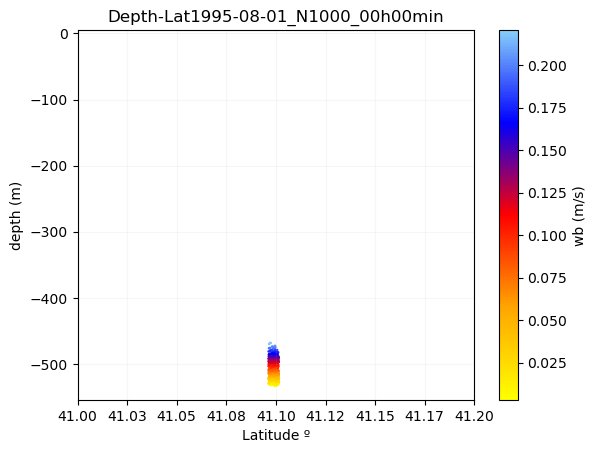

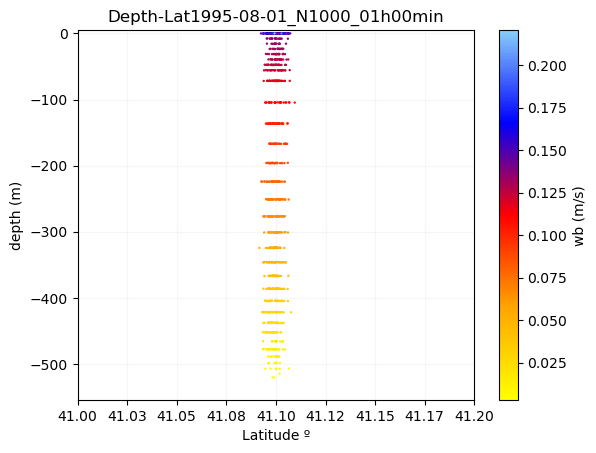

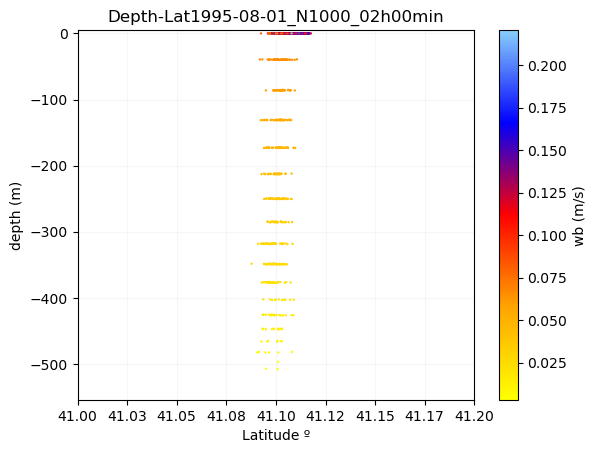

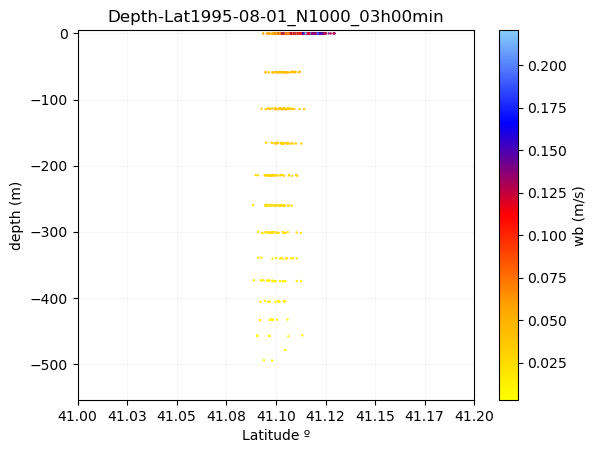

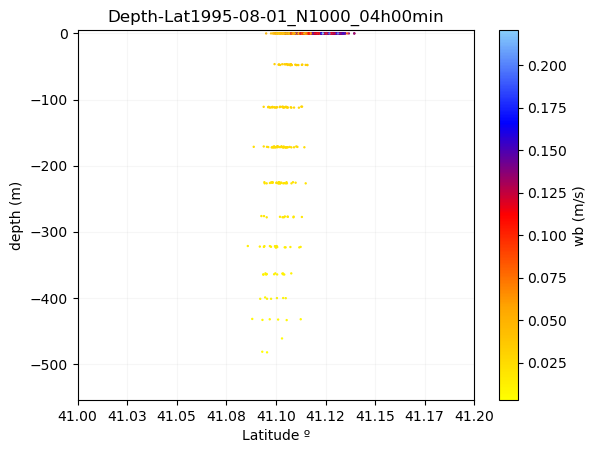

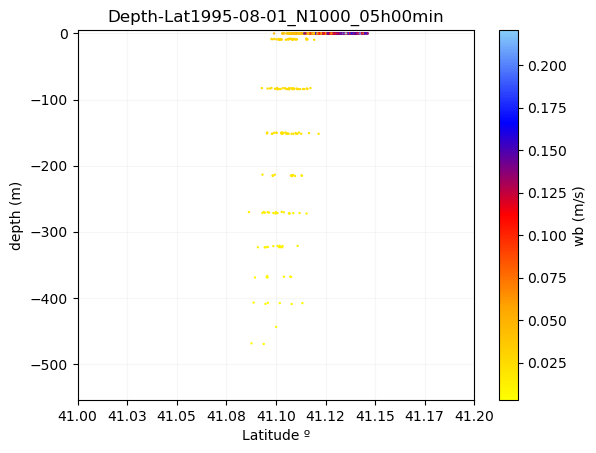

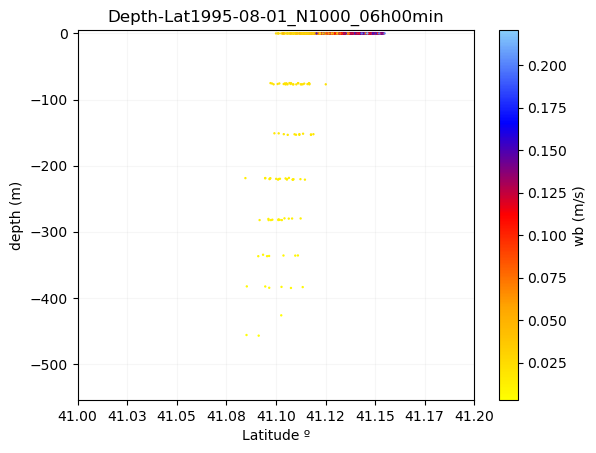

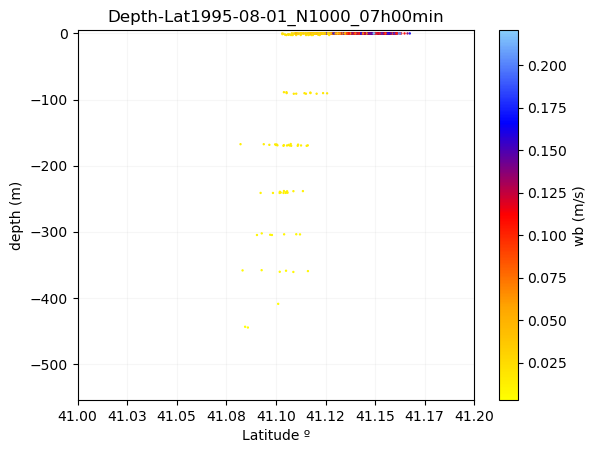

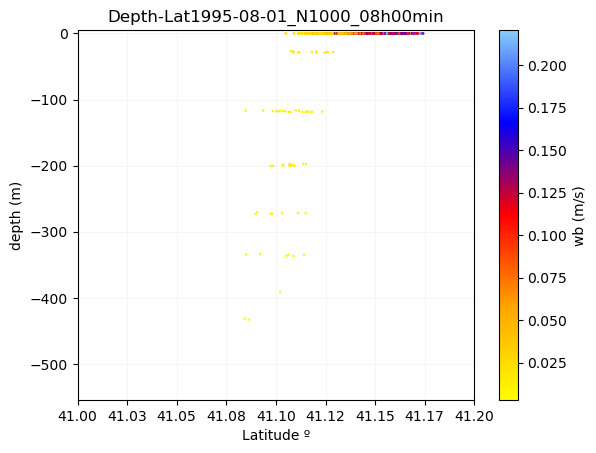

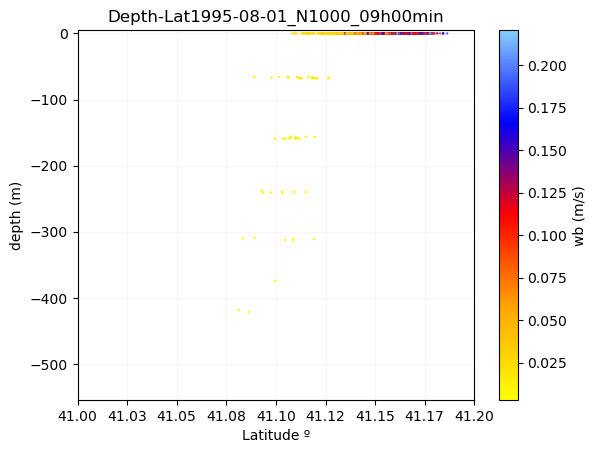

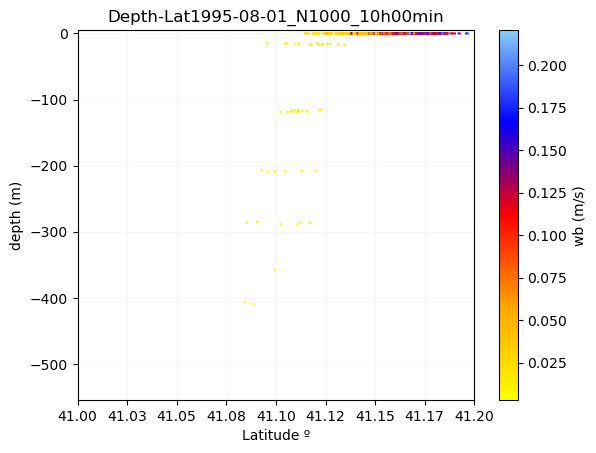

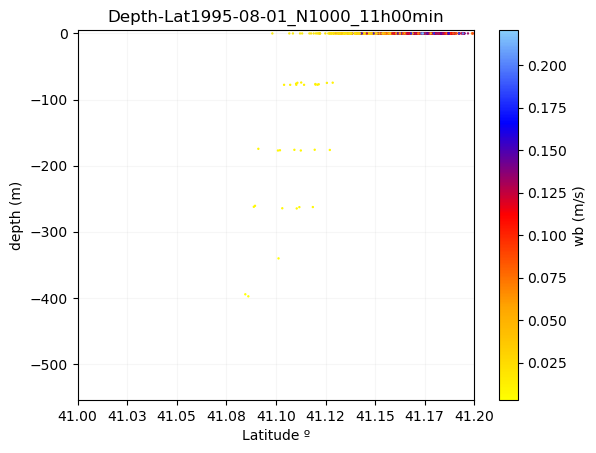

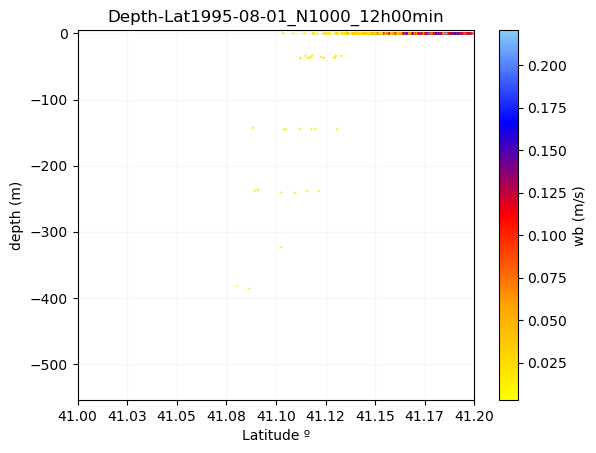

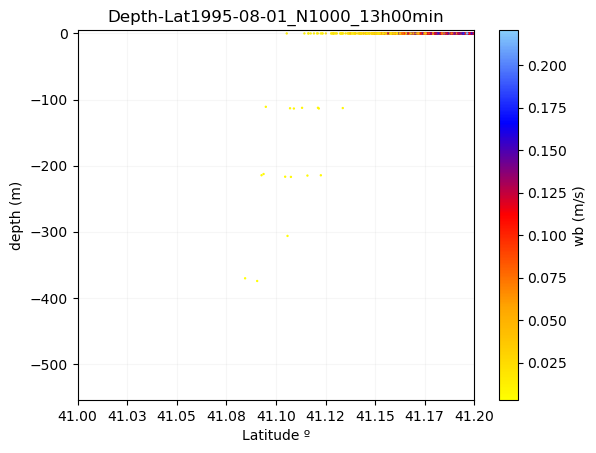

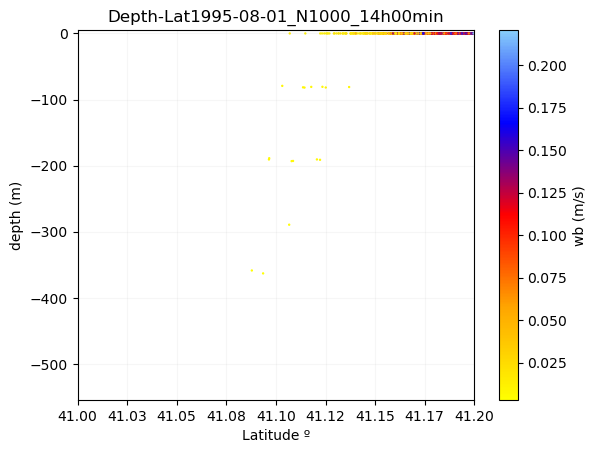

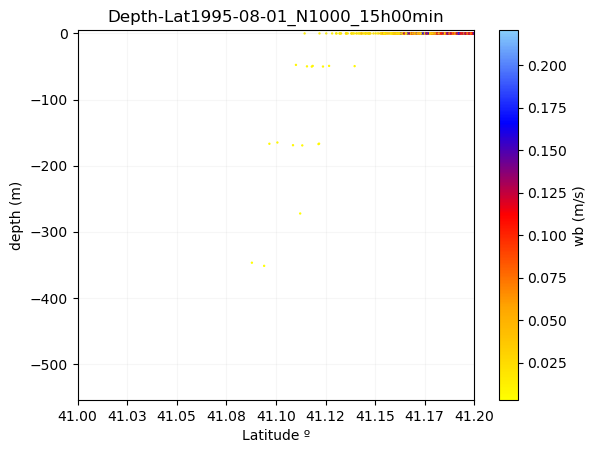

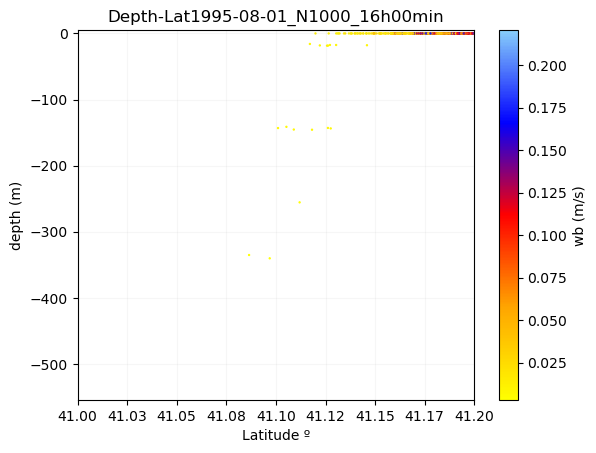

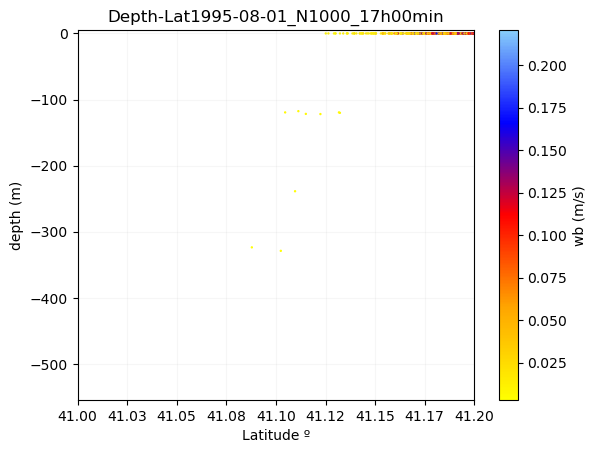

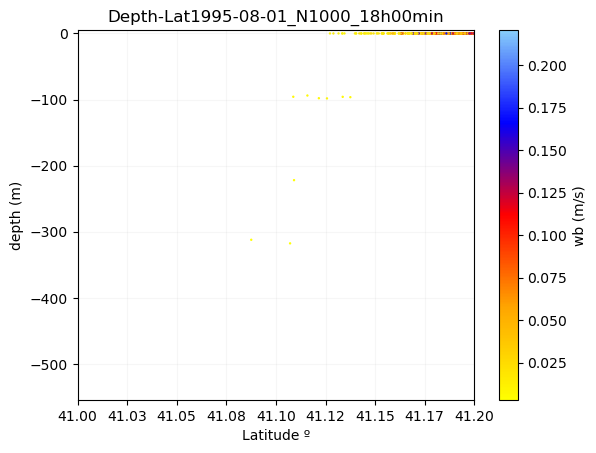

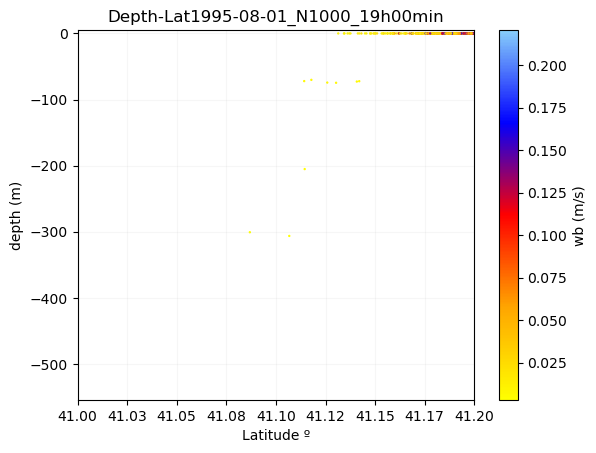

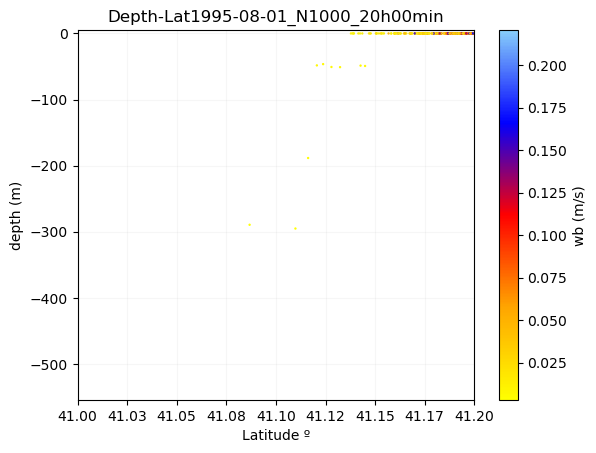

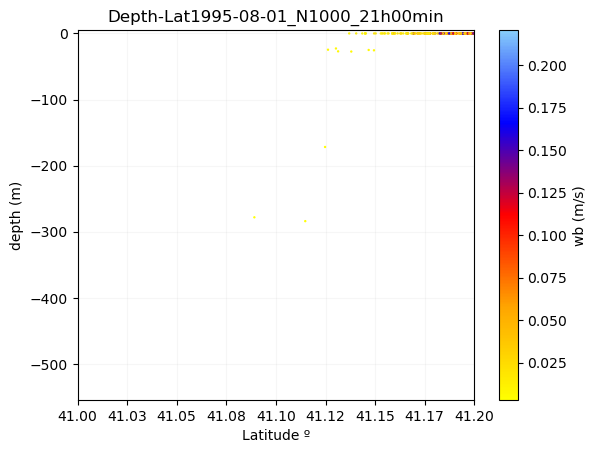

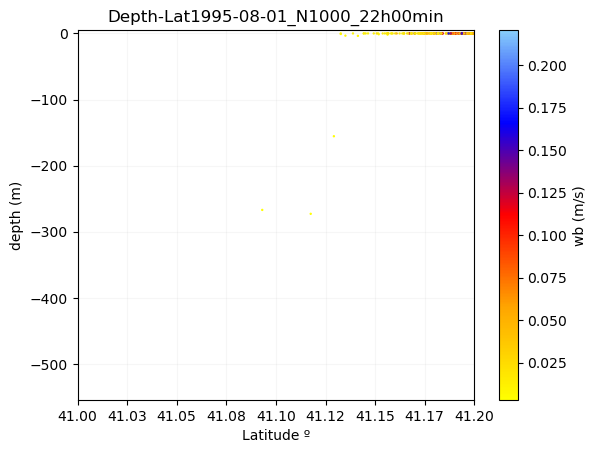

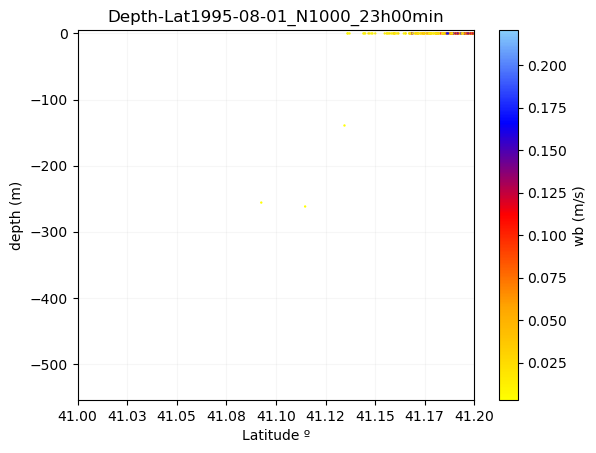

In [11]:
wbmin = -data_xarray['w_buoy'][:,:].max().values
wbmax = -data_xarray['w_buoy'][:,:].min().values

for obs in range (0,nobs,4):   # output observation number are every 6 hours: 4 per day
    fig,ax=plt.subplots()
    ax.grid(alpha = 0.1)
    ax.set_xlabel('Latitude º')
    ax.set_ylabel('depth (m)')
    ax.set_xlim(init_lat - 0.1, init_lat + 0.1)
    ax.set_ylim(- init_depth - 20, 5)

    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f')) 

    colors = ["yellow", "orange", "red", "blue", "lightskyblue"]
    custom_cmap = LinearSegmentedColormap.from_list("my_cmap", colors)

    vsc = ax.scatter(data_xarray['lat'][:,obs], -data_xarray['z'][:,obs], marker='.', s=2, c=-data_xarray['w_buoy'][:,obs], cmap = custom_cmap, vmin = wbmin, vmax = wbmax)
    
    plt.colorbar(vsc, ax=ax, label='wb (m/s)')
    
    total_minutes = int(obs * output_dt)
    hours = total_minutes // 60
    minutes = total_minutes % 60
    time_str = f"{hours:02d}h{minutes:02d}min"

    title = 'Depth-Lat'+np.datetime_as_string(speedxy.time_counter, "D") + '_N' + str(npart) + "_" + time_str

    ax.set_title(title, fontsize=12)
    
    
    # Save the current figure to a file

    fig.savefig(os.path.join(plot_folder_path, title + ".png"), bbox_inches='tight', dpi=300)

C:\Users\Giulia\AppData\Local\Temp\ipykernel_12036\1986303939.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots()


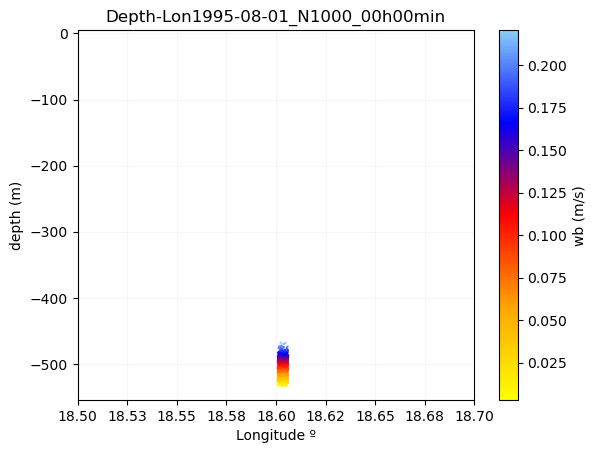

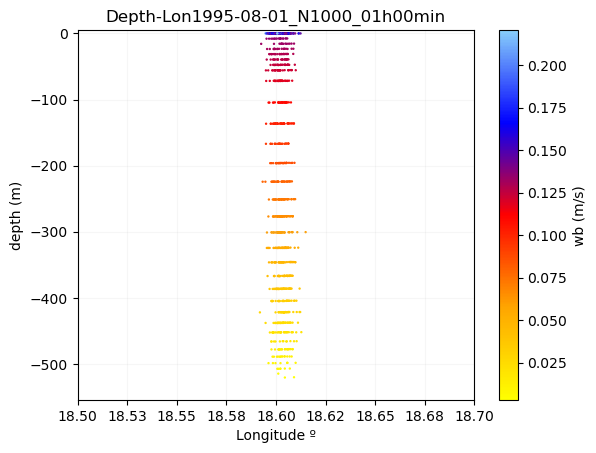

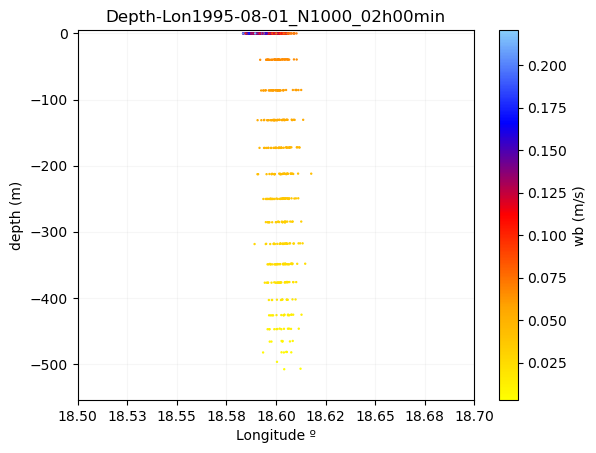

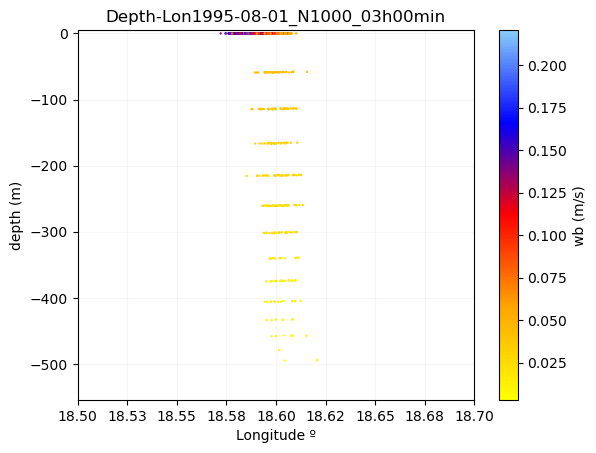

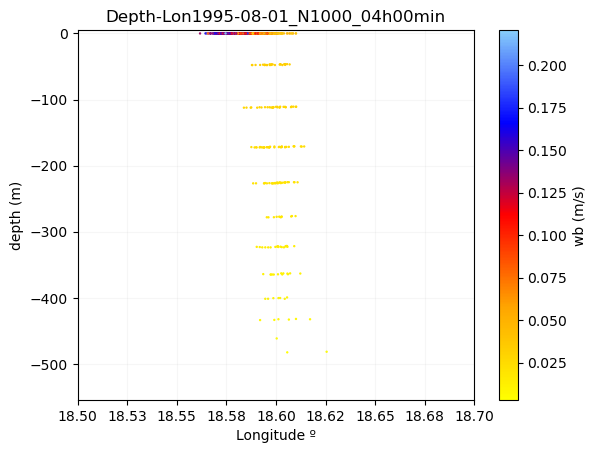

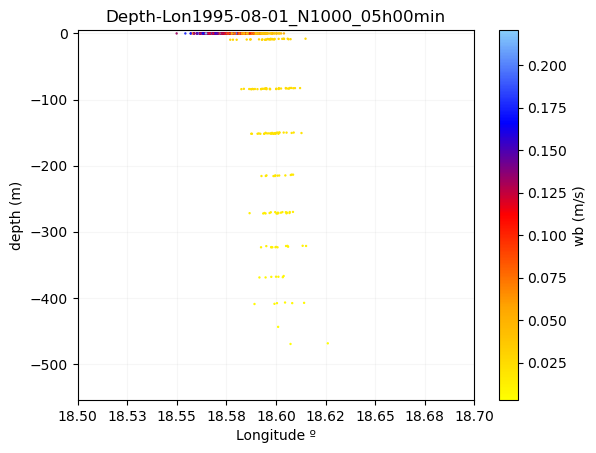

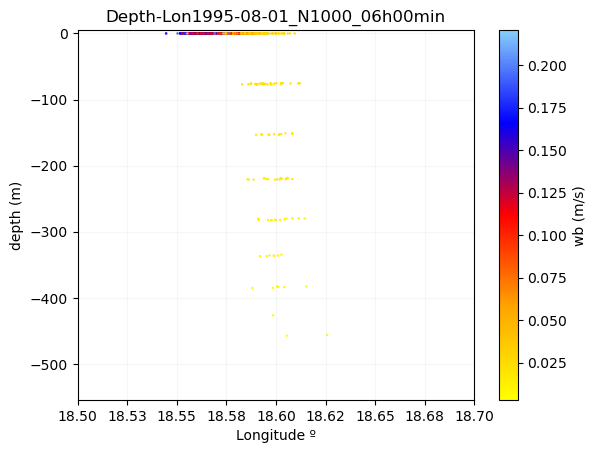

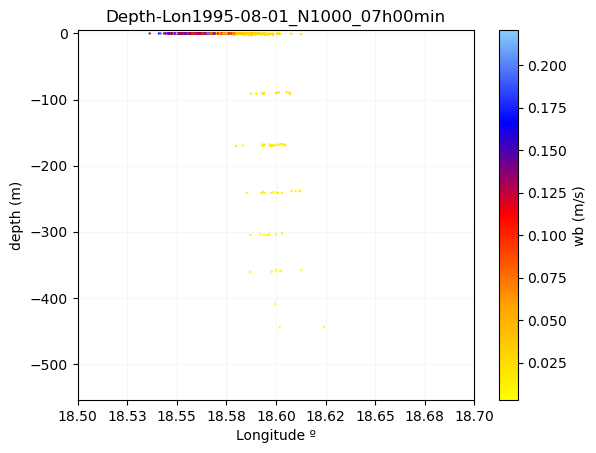

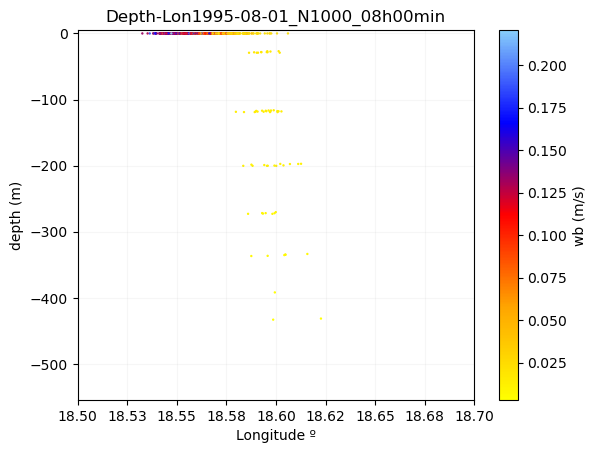

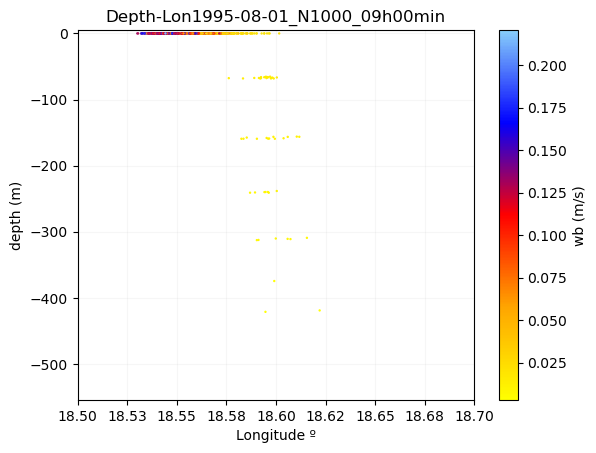

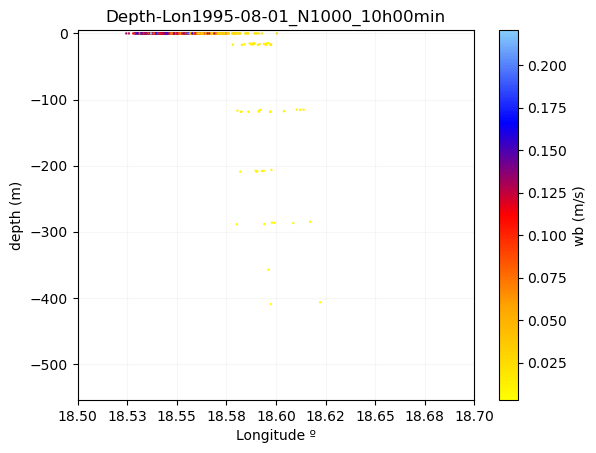

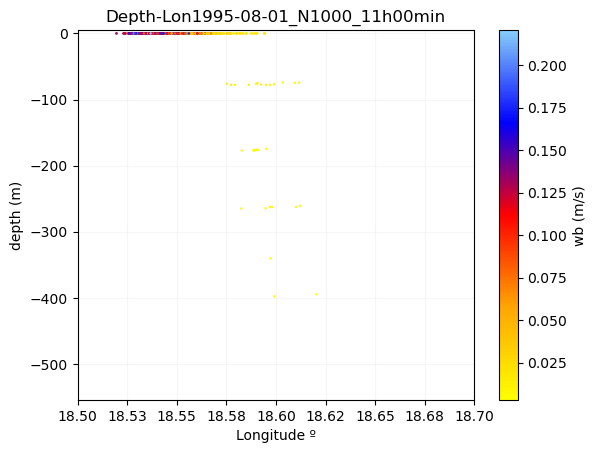

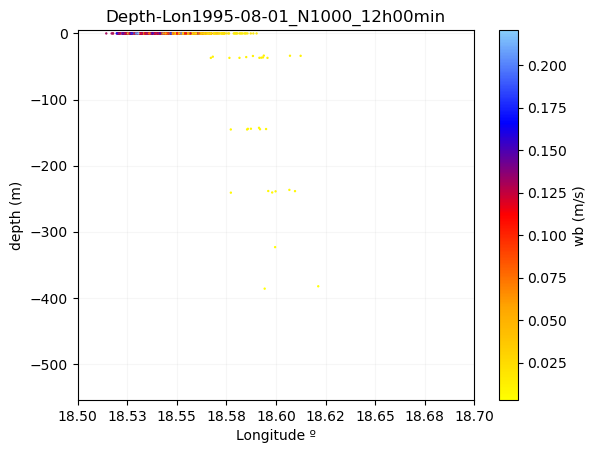

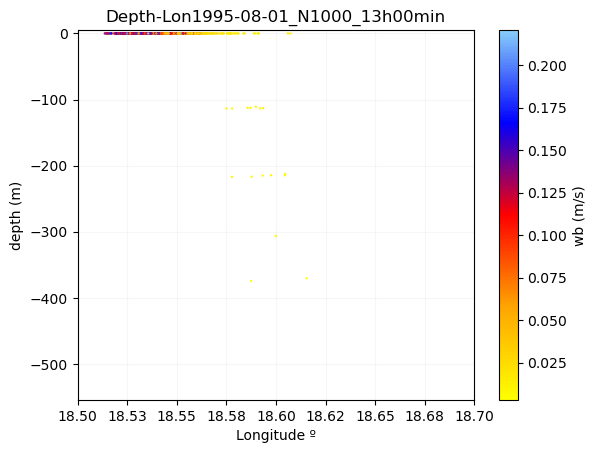

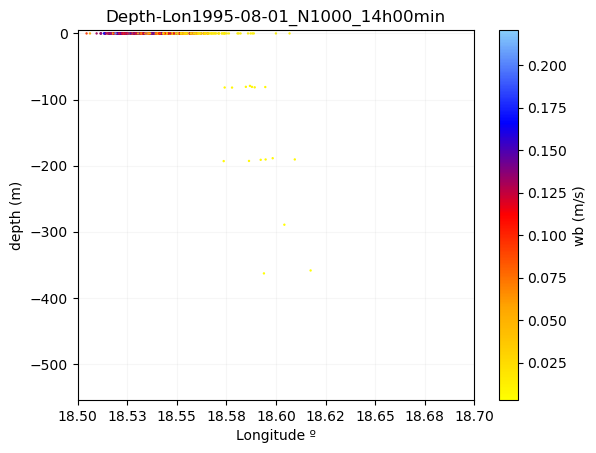

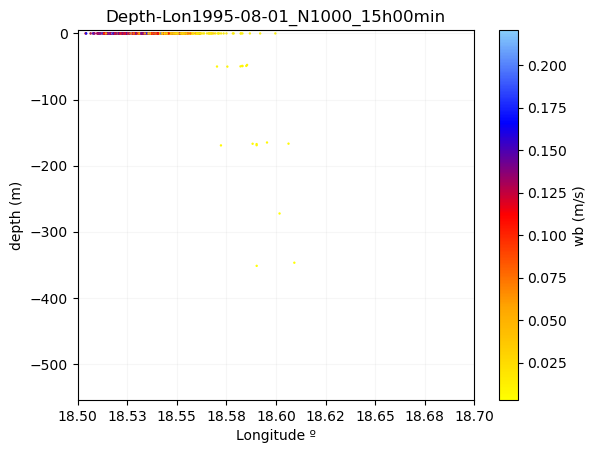

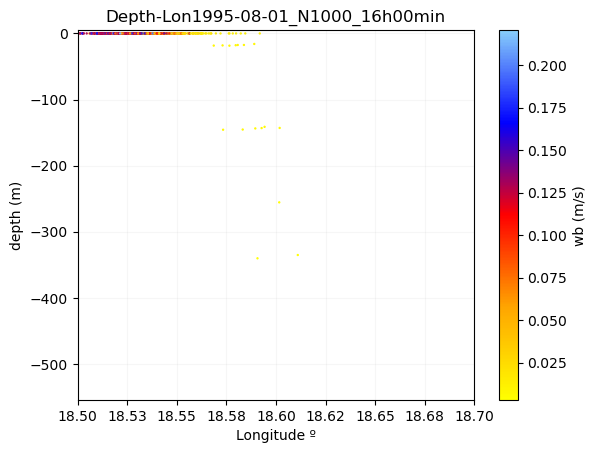

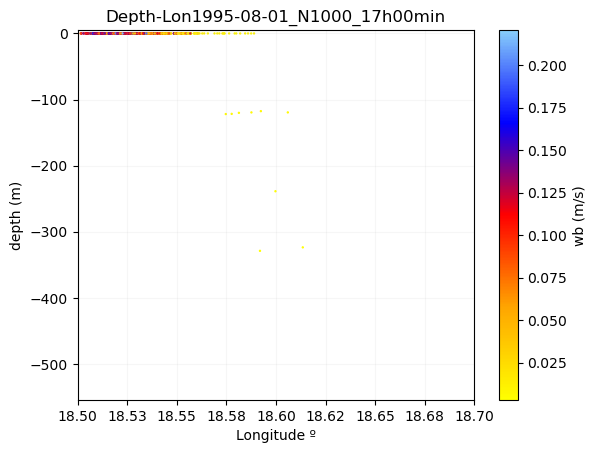

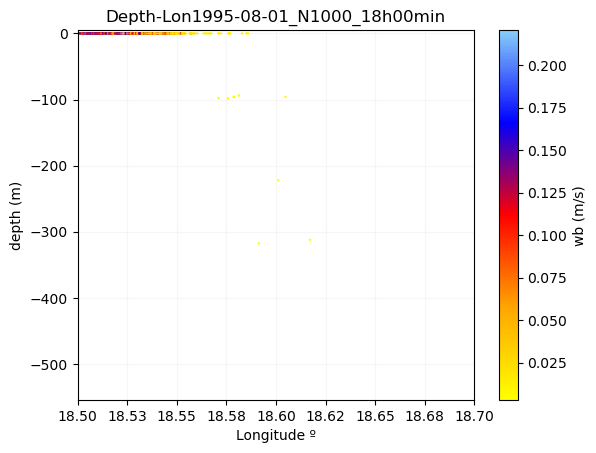

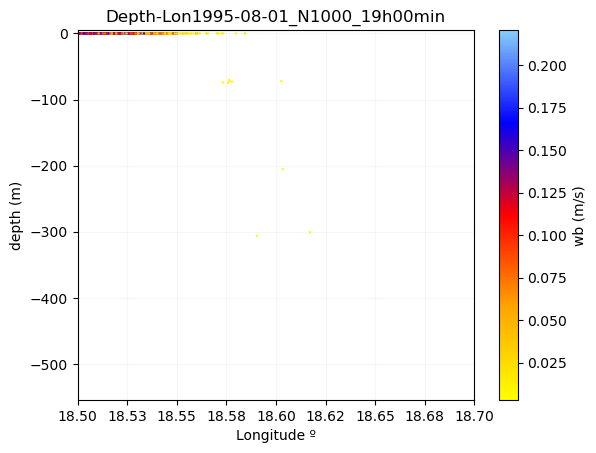

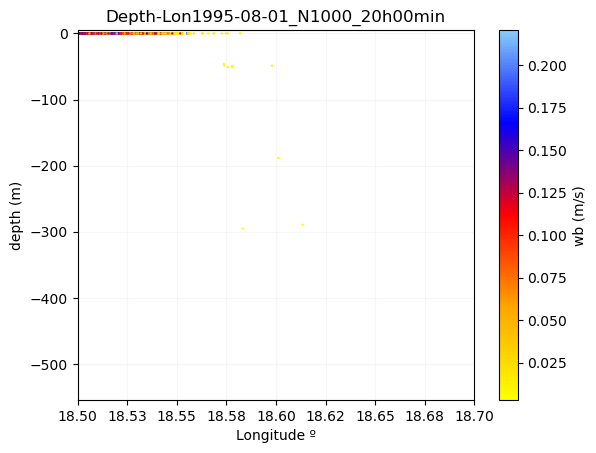

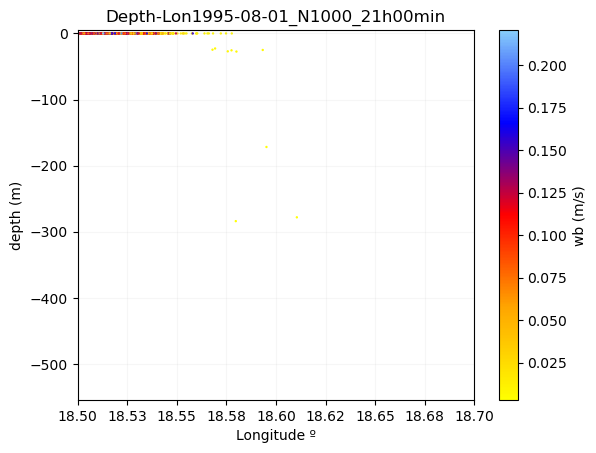

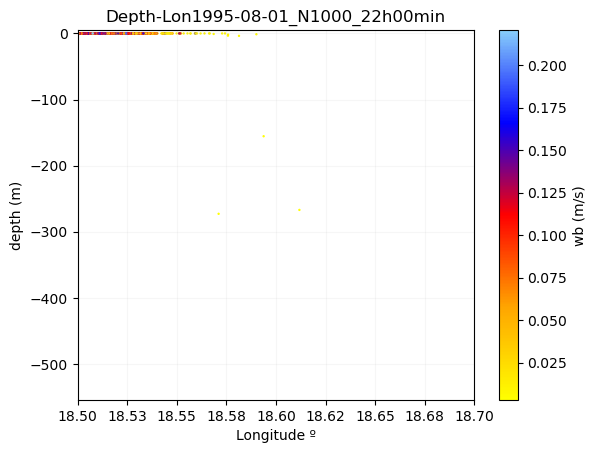

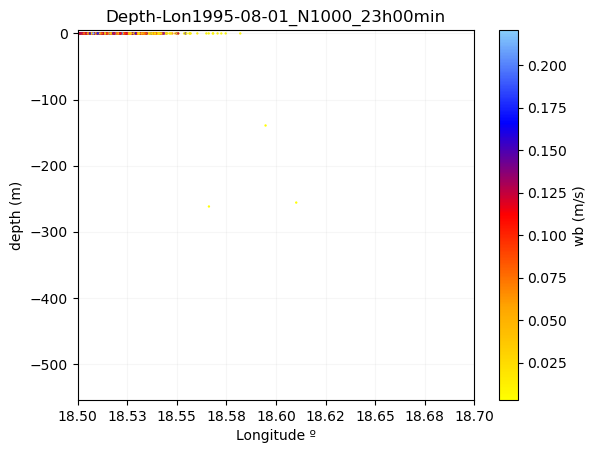

In [12]:
wbmin = -data_xarray['w_buoy'][:,:].max().values
wbmax = -data_xarray['w_buoy'][:,:].min().values

for obs in range (0,nobs,4):  
    fig,ax=plt.subplots()
    ax.grid(alpha = 0.1)
    ax.set_xlabel('Longitude º')
    ax.set_ylabel('depth (m)')
    ax.set_xlim(init_lon - 0.1, init_lon + 0.1)
    ax.set_ylim(- init_depth - 20, 5)

    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f')) 

    

    colors = ["yellow", "orange", "red", "blue", "lightskyblue"]
    custom_cmap = LinearSegmentedColormap.from_list("my_cmap", colors)

    vsc = ax.scatter(data_xarray['lon'][:,obs], -data_xarray['z'][:,obs], marker='.', s=2, c=-data_xarray['w_buoy'][:,obs], cmap = custom_cmap, vmin = wbmin, vmax = wbmax)
    
    plt.colorbar(vsc, ax=ax, label='wb (m/s)')
    
    total_minutes = int(obs * output_dt)
    hours = total_minutes // 60
    minutes = total_minutes % 60
    time_str = f"{hours:02d}h{minutes:02d}min"

    title = 'Depth-Lon'+np.datetime_as_string(speedxy.time_counter, "D") + '_N' + str(npart) + "_" + time_str

    ax.set_title(title, fontsize=12)
    

    
    # Save the current figure to a file

    fig.savefig(os.path.join(plot_folder_path, title + ".png"), bbox_inches='tight', dpi=300)